# Autoencoder Application: Denoising Graphene EM Images


Electron microscopy (EM) images of graphene can be used to constrain the lifetime and evolution of structural defects. However, exposing them to the EM beam will induce their decay and thus interfere with any conclusions made. To prevent such interference, the samples can be imaged at lower doses, but doing so will also decrease the signal-to-noise ratio (SNR). We wish to reduce the noise while preserving the underlying atomic structure in the image.

In this notebook, we will train an autoencoder that transforms a noisy EM image of graphene to a clean one. Different from [autoencoder_basics.ipynb](autoencoder_basics.ipynb), the input and output images will be different in this case.

In [1]:
import os
import sys
import time

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path + 'sciml-workshop/'
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]
    

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {bucket_name} 

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

apt -qq update
apt -qq install s3fs fuse
mkdir -p $2
s3fs $3 $2 -o allow_other,use_path_request_style,no_check_certificate,public_bucket=1,ssl_verify_hostname=0,host=https://s3.echo.stfc.ac.uk,url=https://s3.echo.stfc.ac.uk

Running notebook locally.


---

# The Iterable Dataset

Similar to [CNN_practical.ipynb](../CNN/CNN_practical.ipynb), we will create a `torch.utils.data.IterableDataset` class that uses a genrator to load the data. This type of dataset is useful when the data doesn't fit in memory or when random access is not required.. The dataset contains two sets of images, respectively named "noise" and "clean". There are totally 1000 pairs of noisy and clean images in the file. We will also normalise the pixel values to [-1, 1].

Note: When using an IterableDataset, the `batch_size` is typically handled in the dataset or generator itself, so we set `batch_size=None` in the `DataLoader`.

In [4]:
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader
from torchvision import transforms as T

# normalize
def normalize(X, Y):
    X = 2 * (X - X.min()) / (X.max() - X.min()) - 1
    Y = 2 * (Y - Y.min()) / (Y.max() - Y.min()) - 1
    return X, Y
    

class HDF5IterableDataset(IterableDataset):
    def __init__(self, path, batch_size=128):
        """
        PyTorch IterableDataset for HDF5 data stored on disk.

        Args:
            path: Path to the HDF5 file.
            batch_size: Number of images to load at a time from disk.
        """
        self.path = path
        self.batch_size = batch_size
        
    def __len__(self, ):
        with h5py.File(self.path, 'r') as handle:
            n_samples, h, w, c = handle['noisey'].shape
        return n_samples
        
    def hdf_generator(self):
        """Generator that yields batches of noisy and clean data."""
        with h5py.File(self.path, 'r') as handle:
            n_samples, h, w, c = handle['noisey'].shape
            for i in range(0, n_samples, self.batch_size):
                noise = handle['noisey'][i:i + self.batch_size].astype(np.float32)
                clean = handle['clean'][i:i + self.batch_size].astype(np.float32)
                
                noise, clean = normalize(noise, clean)
                
                yield np.rollaxis(noise, 3, 1), np.rollaxis(clean, 3, 1)

    def __iter__(self):
        """Returns an iterator over the dataset."""
        return iter(self.hdf_generator())
        

BATCH_SIZE = 64

# Create the iterable dataset
train_dataset = HDF5IterableDataset(path=data_path + 'sciml-workshop/em-data/train.h5', batch_size=BATCH_SIZE)

# DataLoader to handle batching, here batch_size should be None because the dataset itself yields batches
train_dataloader = DataLoader(train_dataset, batch_size=None, shuffle=False)

# Check the DataLoader
for noisy, clean in train_dataloader:
    # Perform training operations here
    print(noisy.shape, clean.shape)
    break


torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64])


### Plot examples

Now we can plot a could of examples. The noisy images displayed in the top row will be the input for our autoencoder, and the corresponding clean ones in the bottom row the output for our autoencoder. 

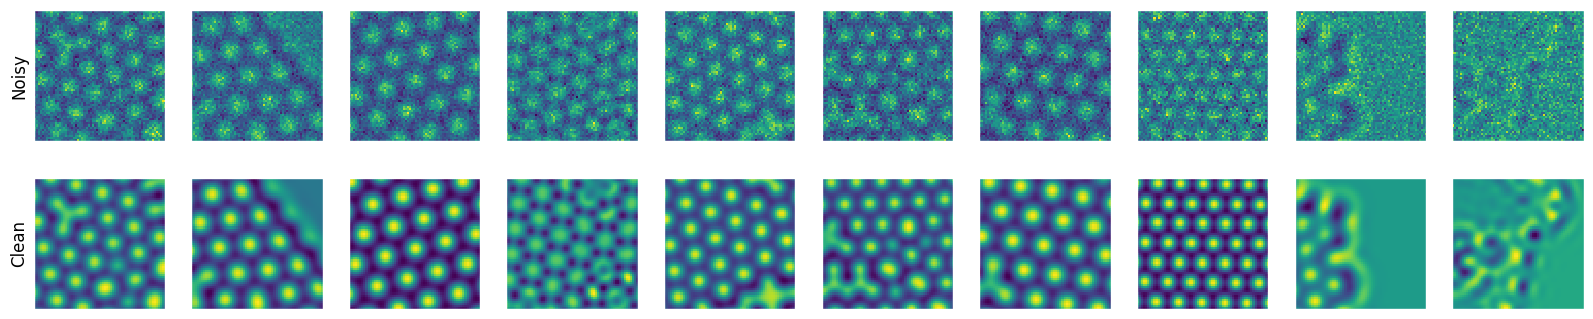

In [5]:
# plot 10 pairs
nplot = 10
fig, axes = plt.subplots(2, nplot, figsize=(nplot * 2, 4))
for ax, img_noise, img_clean in zip(axes.T, noisy[:nplot], clean[:nplot]):
    ax[0].matshow(np.squeeze(img_noise))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].matshow(np.squeeze(img_clean))
    ax[1].set_xticks([])
    ax[1].set_yticks([])   
axes[0, 0].set_ylabel('Noisy', c='k')
axes[1, 0].set_ylabel('Clean', c='k')
plt.show()

---

# Denoising by Autoencoder

## 1. Network architecture

We provide the following suggested network architecture, using multiple levels of convolutional layers for encoding and decoding. 

In this network, we employ a technique called **skip connections**, as implemented by the variable `skip_layers`. Here "skip" means that the information will be teleported from the encoder to the decoder, skipping the bottleneck. The skip connections are introduced to compensate for the information loss because of encoding and decoding, which can help the autoencoder to reconstruct denoised images with less artefacts (such as aliasing and patching).


In [6]:
import torch
from torch import nn
from torch.nn import functional as F

def enc_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
    ) 

def dec_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size, stride=stride, padding=padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
    )
    
class DenoisingAE(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # encoder
        self.enc_conv1 = enc_block(in_channels, 8) 
        self.enc_conv2 = enc_block(8, 16)
        self.enc_conv3 = enc_block(16, 32)
        
        # bottleneck
        self.bottleneck = enc_block(32, 64)

        # upsample layers
        self.upsample = nn.Upsample(scale_factor=2)

        # decoder layers
        self.dec_conv1 = dec_block(96, 32)
        self.dec_conv2 = dec_block(48, 16)
        self.dec_conv3 = dec_block(24, 8)

        # output
        self.out = nn.ConvTranspose2d(8, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        
        # print('x:', x.shape)
        
        skip_layers = []
        
        x = self.enc_conv1(x)   # [8, 64, 64]
        skip_layers.append(x)   # [8, 64, 64]
        x = self.maxpool(x)     # [8, 32, 32]
        # print('enc_conv1:', x.shape)
        
        x = self.enc_conv2(x)   # [16, 32, 32]
        skip_layers.append(x)   # [16, 32, 32]
        x = self.maxpool(x)     # [16, 16, 16]
        # print('enc_conv2:', x.shape)

        x = self.enc_conv3(x)   # [32, 16, 16]
        skip_layers.append(x)   # [32, 16, 16]
        x = self.maxpool(x)     # [32, 8, 8]
        # print('enc_conv3:', x.shape)
        
        x = self.bottleneck(x)  # [64, 8, 8]
        # print('bottleneck:', x.shape)

        x = self.upsample(x)    # [64, 16, 16]
        x = torch.concat([x, skip_layers.pop(-1)], dim=1)    # [96, 16, 16]
        x = self.dec_conv1(x)   # [32, 16, 16]
        # print('dec_conv1:', x.shape)
        
        x = self.upsample(x)    # [32, 32, 32]
        x = torch.concat([x, skip_layers.pop(-1)], dim=1)   # [48, 32, 32]
        x = self.dec_conv2(x)   # [16, 32, 32]
        # print('dec_conv2:', x.shape)

        x = self.upsample(x)    # [16, 64, 64]
        x = torch.concat([x, skip_layers.pop(-1)], dim=1)    # [24, 64, 64]
        x = self.dec_conv3(x)   # [8, 64, 64]
        # print('dec_conv3:', x.shape)

        x = self.out(x)

        return x

## Compile the model 

In [7]:
model = DenoisingAE()
print(clean.shape)
out = model(clean)
print(out.shape)

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])


## 2. Define the loss function

Now we compile the model using a custom loss function based on the structural similarity index measure ([SSIM](https://en.wikipedia.org/wiki/Structural_similarity)). Compared to pixel-wise measurements (such as mean squared error) that estimate absolute errors, SSIM quantifies the similarity in structural information and thus better serves our purpose. Our implementation of SSIM is based on `torchmetrics.image.StructuralSimilarityIndexMeasure`. We also add the mean absolute error (MAE) to the loss function to regularise the solution.

In [9]:
# SSIM loss
from torchmetrics.image import StructuralSimilarityIndexMeasure

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
mae = nn.L1Loss()

def weighted_ssim_loss(y_pred, y_true):
    return 1 - ssim(y_pred, y_true) + 0.4 * mae(y_pred, y_true)


## 3. Train the model

We need `epochs=50` to obtain an acceptable denoising quality, which will take about 2 minutes for training. Use more epochs (>500) to improve the accuracy.

In [10]:
# define a train function
def train(dataloader, model, loss_fn, optimizer, device):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    
    train_loss, train_error = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        # place tensors to device
        X, y = X.to(device), y.to(device)

        # Forward pass 
        pred_y = model(X)

        # compute loss
        loss = loss_fn(pred_y, X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.detach().item()
        train_error += loss.detach().item()
    
    train_loss /= num_batches
    train_error /= num_batches
    
    return train_loss, train_error

# define a test function to evaluate the model
def test(dataloader, model, loss_fn, device):
    # set the model to eval mode
    model.eval()
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_error = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # inference/prediction
            pred_y = model(X)

            # compute test loss and accuracy
            test_error += loss_fn(pred_y, X).item()
            
    test_error /= num_batches

    return test_error, test_error

def trainer(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    
    start = time.time()
    
    h = dict(train_loss=[], test_loss=[], train_error=[], test_error=[])
    
    for t in range(epochs):
        print(f"\nEpoch {t+1}/{epochs}: ", end='')
        
        train_loss, train_error = train(train_dataloader, model, loss_fn, optimizer, device)

        test_loss, test_error = test(test_dataloader, model, loss_fn, device)
        
        print(f"train_loss: {train_loss:0.3f}, train_error: {(train_error):0.3f}, test_error: {(test_error):0.3f}")


        h['train_loss'].append(train_loss)
        h['test_loss'].append(test_loss)
        h['train_error'].append(train_error)
        h['test_error'].append(test_error)

    print(f"Done in {time.time()-start:.3f}secs!")
    
    return h

epochs = 50

model = DenoisingAE().to(device)

# create a optimizer with constant learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = trainer(model, train_dataloader, train_dataloader, optimizer, weighted_ssim_loss, epochs, device)


Epoch 1/50: 

/home/ubuntu/miniconda3/envs/sciml-workshop/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


train_loss: 0.021, train_error: 0.021, test_error: 0.019

Epoch 2/50: train_loss: 0.015, train_error: 0.015, test_error: 0.018

Epoch 3/50: train_loss: 0.011, train_error: 0.011, test_error: 0.012

Epoch 4/50: train_loss: 0.009, train_error: 0.009, test_error: 0.009

Epoch 5/50: train_loss: 0.008, train_error: 0.008, test_error: 0.006

Epoch 6/50: train_loss: 0.008, train_error: 0.008, test_error: 0.005

Epoch 7/50: train_loss: 0.008, train_error: 0.008, test_error: 0.007

Epoch 8/50: train_loss: 0.008, train_error: 0.008, test_error: 0.006

Epoch 9/50: train_loss: 0.007, train_error: 0.007, test_error: 0.005

Epoch 10/50: train_loss: 0.007, train_error: 0.007, test_error: 0.005

Epoch 11/50: train_loss: 0.007, train_error: 0.007, test_error: 0.004

Epoch 12/50: train_loss: 0.006, train_error: 0.006, test_error: 0.005

Epoch 13/50: train_loss: 0.006, train_error: 0.006, test_error: 0.004

Epoch 14/50: train_loss: 0.005, train_error: 0.005, test_error: 0.004

Epoch 15/50: train_loss: 0.

## 4. Denoise the images

Finally, we can use our trained autoencoder to denoise the images:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# denoise by predict
with torch.no_grad():
    denoised = model(noisy)
    
# plot results
nplot = 5
fig, axes = plt.subplots(3, nplot, figsize=(nplot * 2, 6))
for ax, img_noise, img_clean, img_denoised in zip(axes.T, noisy[:nplot], clean[:nplot], denoised[:nplot]):
    ax[0].matshow(np.squeeze(img_noise))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].matshow(np.squeeze(img_clean))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].matshow(np.squeeze(img_denoised))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
axes[0, 0].set_ylabel('Noisy', c='k')
axes[1, 0].set_ylabel('Clean', c='k')
axes[2, 0].set_ylabel('Denoised', c='k')
plt.show()
```
    
</p>
</details>

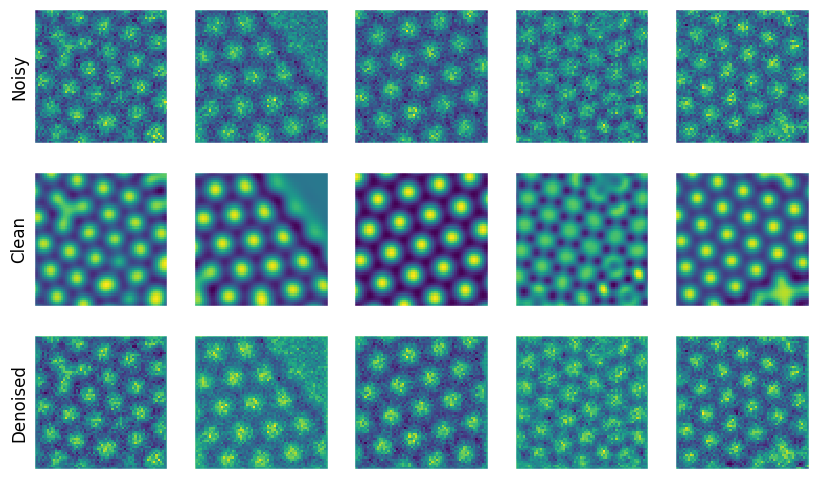

In [11]:
# denoise by predict
with torch.no_grad():
    denoised = model(noisy.to(device)).cpu()
    
# plot results
nplot = 5
fig, axes = plt.subplots(3, nplot, figsize=(nplot * 2, 6))
for ax, img_noise, img_clean, img_denoised in zip(axes.T, noisy[:nplot], clean[:nplot], denoised[:nplot]):
    ax[0].matshow(np.squeeze(img_noise))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].matshow(np.squeeze(img_clean))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].matshow(np.squeeze(img_denoised))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
axes[0, 0].set_ylabel('Noisy', c='k')
axes[1, 0].set_ylabel('Clean', c='k')
axes[2, 0].set_ylabel('Denoised', c='k')
plt.show()

---

## Exercises

Suppose that we have a set of noisy images and a set of clean images but they are completely independent; e.g., they can be obtained from different samples and can be different in size. Such a situation commonly occurs when the "noisy" data are collected from the nature while we can synthesise the "clean" data in the laboratory. 

Design and train an autoencoder using the clean images as *both* its input and output and use the autoencoder to denoise the noisy images. Note that because the input and output are now identical, the network architecture can be simpler and the skip connections are no longer required. 

**Hint**: To get the training dataset with the clean images as both input and output, we can simply do

```python
dataset_clean_as_both_IO = dataset.map(lambda X, Y: (Y, Y))
```